In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init, image
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

# 13. Computer Vision
Many applications in the area of computer vision are closely related to our daily lives, now and in the future, whether medical diagnostics, driverless vehicles, camera monitoring, or smart filters. In recent years, deep learning technology has greatly enhanced computer vision systems' performance. It can be said that the most advanced computer vision applications are nearly inseparable from deep learning.

We have introduced deep learning models commonly used in the area of computer vision in the chapter "Convolutional Neural Networks" and have practiced simple image classification tasks. In this chapter, we will introduce image augmentation and fine tuning methods and apply them to image classification. Then, we will explore various methods of object detection. After that, we will learn how to use fully convolutional networks to perform semantic segmentation on images. Then, we explain how to use style transfer technology to generate images that look like the cover of this book. Finally, we will perform practice exercises on two important computer vision datasets to review the content of this chapter and the previous chapters.

## 13.1 Image Augmentation
We mentioned that large-scale datasets are prerequisites for the successful application of deep neural networks in `Section 7.1`. Image augmentation technology expands the scale of training datasets by making a series of random changes to the training images to produce similar, but different, training examples. Another way to explain image augmentation is that randomly changing training examples can reduce a model's dependence on certain properties, thereby improving its capability for generalization. For example, we can crop the images in different ways, so that the objects of interest appear in different positions, reducing the model's dependence on the position where objects appear. We can also adjust the brightness, color, and other factors to reduce model's sensitivity to color. It can be said that image augmentation technology contributed greatly to the success of `AlexNet`. In this section, we will discuss this technology, which is widely used in computer vision.

### 13.1.1 Common Image Augmentation Method
In this experiment, we will use an image with a shape of $400\times 500$ as an example.

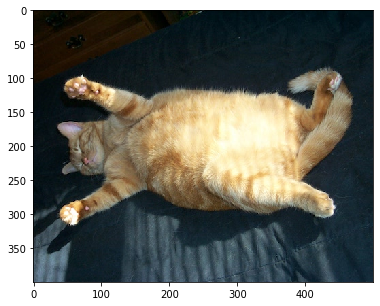

In [2]:
d2l.set_figsize()
img = image.imread('./images/cat1.jpg')
d2l.plt.imshow(img.asnumpy());

Most image augmentation methods have a certain degree of randomness. To make it easier for us to observe the effect of image augmentation, we next define the auxiliary function apply. This function runs the image augmentation method `aug` multiple times on the input image `img` and shows all results.

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

##### Flipping and Cropping
Flipping the image left and right usually does not change the category of the object. This is one of the earliest and most widely used methods of image augmentation. Next, we use the `transforms` module to create the `RandomFlipLeftRight` instance, which introduces a `50%` chance that the image is flipped left and right.

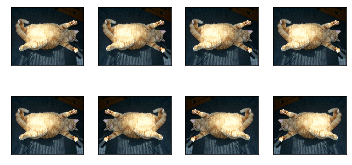

In [4]:
apply(img, gluon.data.vision.transforms.RandomFlipLeftRight())

Flipping up and down is not as commonly used as flipping left and right. However, at least for this example image, flipping up and down does not hinder recognition. Next, we create a `RandomFlipTopBottom` instance for a `50%` chance of flipping the image up and down.

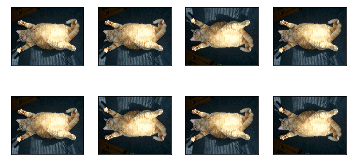

In [5]:
apply(img, gluon.data.vision.transforms.RandomFlipTopBottom())

In the example image we used, the cat is in the middle of the image, but this may not be the case for all images. In `Section 6.5`, we explained that the pooling layer can reduce the sensitivity of the convolutional layer to the target location. In addition, we can make objects appear at different positions in the image in different proportions by randomly cropping the image. This can also reduce the sensitivity of the model to the target position.

In the following code, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels. Unless otherwise stated, the random number between $a$ and $b$ in this section refers to a continuous value obtained by uniform sampling in the interval $[a, b]$.

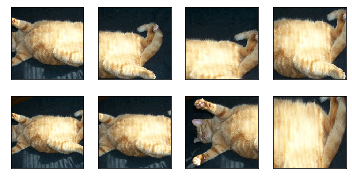

In [6]:
shape_aug = gluon.data.vision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

##### Changing the Color
Another augmentation method is changing colors. We can change four aspects of the image color: brightness, contrast, saturation, and hue. In the example below, we randomly change the brightness of the image to a value between `50%` ($1-0.5$) and `150%` ($1+0.5$) of the original image.

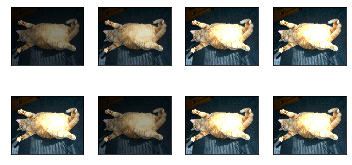

In [7]:
apply(img, gluon.data.vision.transforms.RandomBrightness(0.5))

Similarly, we can randomly change the hue of the image.

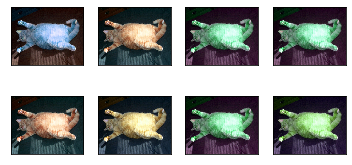

In [8]:
apply(img, gluon.data.vision.transforms.RandomHue(0.5))

We can also create a `RandomColorJitter` instance and set how to randomly change the brightness, contrast, saturation, and hue of the image at the same time.

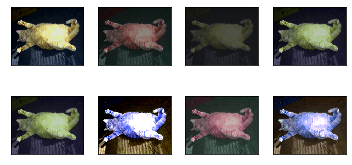

In [9]:
color_aug = gluon.data.vision.transforms.RandomColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img, color_aug)

##### Overlying Multiple Image Augmentation Methods
In practice, we will overlay multiple image augmentation methods. We can overlay the different image augmentation methods defined above and apply them to each image by using a `Compose` instance.

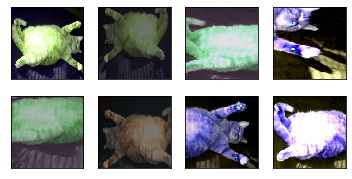

In [10]:
augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(), color_aug, shape_aug])
apply(img, augs)

### 13.1.2 Using an Image Augmentation Training Model
Next, we will look at how to apply image augmentation in actual training. Here, we use the `CIFAR-10` dataset, instead of the `Fashion-MNIST` dataset we have been using. This is because the position and size of the objects in the `Fashion-MNIST` dataset have been normalized, and the differences in color and size of the objects in `CIFAR-10` dataset are more significant. The first 32 training images in the `CIFAR-10` dataset are shown below.

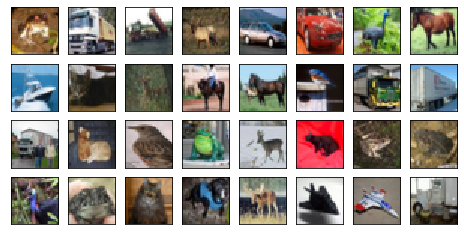

In [11]:
d2l.show_images(gluon.data.vision.CIFAR10(train=True)[0:32][0], 4, 8, scale=1);

In order to obtain definitive results during prediction, we usually only apply image augmentation to the training example, and do not use image augmentation with random operations during prediction. Here, we only use the simplest random left-right flipping method. In addition, we use a `ToTensor` instance to convert minibatch images into the format required by `MXNet`, i.e., 32-bit floating point numbers with the shape of `(batch size, number of channels, height, width)` and value range between 0 and 1.

In [12]:
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor()])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.ToTensor()])

Next, we define an auxiliary function to make it easier to read the image and apply image augmentation. The `transform_first` function provided by `Gluon`'s dataset applies image augmentation to the first element of each training example (image and label), i.e., the element at the top of the image. For detailed descriptions of `DataLoader`, refer to `Section 3.5`.

In [13]:
def load_cifar10(is_train, augs, batch_size):
    return gluon.data.DataLoader(
        gluon.data.vision.CIFAR10(train=is_train).transform_first(augs),
        batch_size=batch_size, 
        shuffle=is_train,
        num_workers=d2l.get_dataloader_workers())

##### Using a Multi-GPU Training Model
We train the `ResNet-18` model described in `Section 7.6` on the `CIFAR-10` dataset. We will also apply the methods described in `Section 12.6` and use a multi-GPU training model.

Next, we define the training function to train and evaluate the model using multiple GPUs.

In [14]:
#@save
def train_batch_ch13(net, features, labels, loss, trainer, ctx_list, split_f=d2l.split_batch):
    X_shards, y_shards = split_f(features, labels, ctx_list)
    with autograd.record():
        pred_shards = [net(X_shard) for X_shard in X_shards]
        ls = [loss(pred_shard, y_shard) for pred_shard, y_shard
              in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()
    # The True flag allows parameters with stale gradients, which is useful
    # later (e.g., in fine-tuning BERT)
    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([float(l.sum()) for l in ls])
    train_acc_sum = sum(d2l.accuracy(pred_shard, y_shard) 
                        for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum

In [15]:
#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               ctx_list=d2l.try_all_gpus(), split_f=d2l.split_batch):
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # Store training_loss, training_accuracy, num_examples, num_features
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(net, features, labels, loss, trainer, ctx_list, split_f)
            metric.add(l, acc, labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0:
                animator.add(epoch + i / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpus(net, test_iter, split_f)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(ctx_list)}')

Now, we can define the `train_with_data_aug` function to use image augmentation to train the model. This function obtains all available GPUs and uses `Adam` as the optimization algorithm for training. It then applies image augmentation to the training dataset, and finally calls the train function just defined to train and evaluate the model.

In [16]:
batch_size, ctx, net = 100, d2l.try_all_gpus(), d2l.resnet18(10)
net.initialize(init=init.Xavier(), ctx=ctx)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, ctx)

Now we train the model using image augmentation of random flipping left and right.

loss 0.165, train acc 0.943, test acc 0.856
261.2 examples/sec on [gpu(0)]


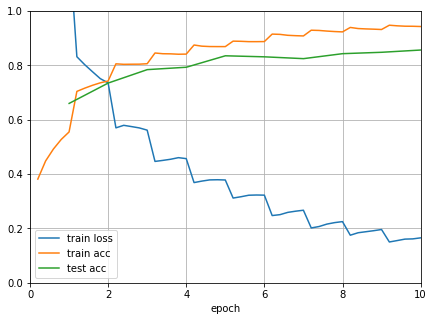

In [17]:
train_with_data_aug(train_augs, test_augs, net)

##### Summary
+ Image augmentation generates random images based on existing training data to cope with overfitting.
+ In order to obtain definitive results during prediction, we usually only apply image augmentation to the training example, and do not use image augmentation with random operations during prediction.
+ We can obtain classes related to image augmentation from Gluon's transforms module.

##### Exercises
1. Train the model without using image augmentation: `train_with_data_aug(no_aug, no_aug)`. Compare training and testing accuracy when using and not using image augmentation. Can this comparative experiment support the argument that image augmentation can mitigate overfitting? Why?
2. Add different image augmentation methods in model training based on the `CIFAR-10` dataset. Observe the implementation results.
3. With reference to the `MXNet` documentation, what other image augmentation methods are provided in `Gluon`'s transforms module?


## 13.2 Fine-Tuning
In earlier chapters, we discussed how to train models on the `Fashion-MNIST` training dataset, which only has 60000 images. We also described ImageNet, the most widely used large-scale image dataset in the academic world, with more than 10 million images and objects of over 1000 categories. However, the size of datasets that we often deal with is usually larger than the first, but smaller than the second.

Assume we want to identify different kinds of chairs in images and then push the purchase link to the user. One possible method is to first find a hundred common chairs, take one thousand different images with different angles for each chair, and then train a classification model on the collected image dataset. Although this dataset may be larger than Fashion-MNIST, the number of examples is still less than one tenth of ImageNet. This may result in the overfitting of the complicated model applicable to ImageNet on this dataset. At the same time, because of the limited amount of data, the accuracy of the final trained model may not meet the practical requirements.

In order to deal with the above problems, an obvious solution is to collect more data. However, collecting and labeling data can consume a lot of time and money. For example, in order to collect the ImageNet datasets, researchers have spent millions of dollars of research funding. Although, recently, data collection costs have dropped significantly, the costs still cannot be ignored.

Another solution is to apply transfer learning to migrate the knowledge learned from the source dataset to the target dataset. For example, although the images in ImageNet are mostly unrelated to chairs, models trained on this dataset can extract more general image features that can help identify edges, textures, shapes, and object composition. These similar features may be equally effective for recognizing a chair.

In this section, we introduce a common technique in transfer learning: `fine tuning`. As shown in `Fig. 13.2.1`, fine tuning consists of the following four steps:
1. Pre-train a neural network model, i.e., the source model, on a source dataset (e.g., the ImageNet dataset).
2. Create a new neural network model, i.e., the target model. This replicates all model designs and their parameters on the source model, except the output layer. We assume that these model parameters contain the knowledge learned from the source dataset and this knowledge will be equally applicable to the target dataset. We also assume that the output layer of the source model is closely related to the labels of the source dataset and is therefore not used in the target model.
3. Add an output layer whose output size is the number of target dataset categories to the target model, and randomly initialize the model parameters of this layer.
4. Train the target model on a target dataset, such as a chair dataset. We will train the output layer from scratch, while the parameters of all remaining layers are fine-tuned based on the parameters of the source model.

### 13.2.1 Hot Dog Recognition
Next, we will use a specific example for practice: hot dog recognition. We will fine-tune the `ResNet` model trained on the ImageNet dataset based on a small dataset. This small dataset contains thousands of images, some of which contain hot dogs. We will use the model obtained by fine tuning to identify whether an image contains a hot dog.

First, import the packages and modules required for the experiment. `Gluon`'s `model_zoo` package provides a common pre-trained model. If you want to get more pre-trained models for computer vision, you can use the `GluonCV Toolkit`.

##### Obtaining the Dataset
The hot dog dataset we use was taken from online images and contains $1,400$ positive images containing hot dogs and the same number of negative images containing other foods. $1,000$ images of various classes are used for training and the rest are used for testing.

We first download the compressed dataset and get two folders `hotdog/train` and `hotdog/test`. Both folders have `hotdog` and `not-hotdog` category subfolders, each of which has corresponding image files.

In [18]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL+'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')

We create two `ImageFolderDataset` instances to read all the image files in the training dataset and testing dataset, respectively.

In [19]:
train_imgs = gluon.data.vision.ImageFolderDataset(os.path.join(data_dir, 'train'))
test_imgs = gluon.data.vision.ImageFolderDataset(os.path.join(data_dir, 'test'))

The first 8 positive examples and the last 8 negative images are shown below. As you can see, the images vary in size and aspect ratio.

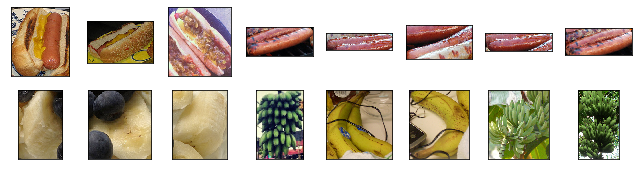

In [20]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

During training, we first crop a random area with random size and random aspect ratio from the image and then scale the area to an input with a height and width of 224 pixels. During testing, we scale the height and width of images to 256 pixels, and then crop the center area with height and width of 224 pixels to use as the input. In addition, we normalize the values of the three RGB `(red, green, and blue)` color channels. The average of all values of the channel is subtracted from each value and then the result is divided by the standard deviation of all values of the channel to produce the output.

In [21]:
# We specify the mean and variance of the three RGB channels to normalize the
# image channel
normalize = gluon.data.vision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomResizedCrop(224),
    gluon.data.vision.transforms.RandomFlipLeftRight(),
    gluon.data.vision.transforms.ToTensor(),
    normalize])

test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),
    gluon.data.vision.transforms.CenterCrop(224),
    gluon.data.vision.transforms.ToTensor(),
    normalize])

##### Defining and Initializing the Model
We use `ResNet-18`, which was pre-trained on the ImageNet dataset, as the source model. Here, we specify `pretrained=True` to automatically download and load the pre-trained model parameters. The first time they are used, the model parameters need to be downloaded from the Internet.

In [22]:
pretrained_net = gluon.model_zoo.vision.resnet18_v2(pretrained=True)

The pre-trained source model instance contains two member variables: features and output. The former contains all layers of the model, except the output layer, and the latter is the output layer of the model. The main purpose of this division is to facilitate the fine tuning of the model parameters of all layers except the output layer. The member variable output of source model is given below. As a fully connected layer, it transforms `ResNet`'s final global average pooling layer output into 1000 class output on the ImageNet dataset.

In [23]:
pretrained_net.output

Dense(512 -> 1000, linear)

We then build a new neural network to use as the target model. It is defined in the same way as the pre-trained source model, but the final number of outputs is equal to the number of categories in the target dataset. In the code below, the model parameters in the member variable features of the target model instance `finetune_net` are initialized to model parameters of the corresponding layer of the source model. Because the model parameters in features are obtained by pre-training on the ImageNet dataset, it is good enough. Therefore, we generally only need to use small learning rates to "fine-tune" these parameters. In contrast, model parameters in the member variable output are randomly initialized and generally require a larger learning rate to learn from scratch. Assume the learning rate in the Trainer instance is $\eta$ and use a learning rate of $10\eta$ to update the model parameters in the member variable output.

In [24]:
finetune_net = gluon.model_zoo.vision.resnet18_v2(classes=2)
finetune_net.features = pretrained_net.features
finetune_net.output.initialize(init.Xavier())
# The model parameters in output will be updated using a learning rate ten
# times greater
finetune_net.output.collect_params().setattr('lr_mult', 10)

##### Fine Tuning the Model
We first define a training function `train_fine_tuning` that uses fine tuning so it can be called multiple times.

In [25]:
def train_fine_tuning(net, learning_rate, batch_size=24, num_epochs=10):
    train_iter = gluon.data.DataLoader(train_imgs.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gluon.data.DataLoader(test_imgs.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': learning_rate, 'wd': 0.001})
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, ctx)

We set the learning rate in the `Trainer` instance to a smaller value, such as 0.01, in order to fine-tune the model parameters obtained in pretraining. Based on the previous settings, we will train the output layer parameters of the target model from scratch using a learning rate ten times greater.

loss 0.185, train acc 0.930, test acc 0.843
74.7 examples/sec on [gpu(0)]


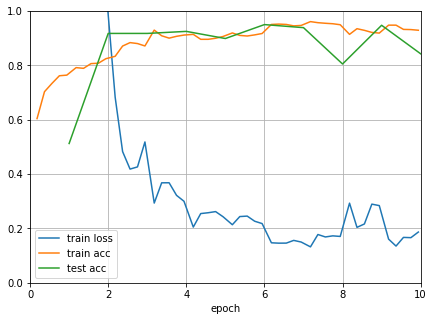

In [26]:
train_fine_tuning(finetune_net, 0.01)

For comparison, we define an identical model, but initialize all of its model parameters to random values. Since the entire model needs to be trained from scratch, we can use a larger learning rate.

loss 0.364, train acc 0.841, test acc 0.858
75.4 examples/sec on [gpu(0)]


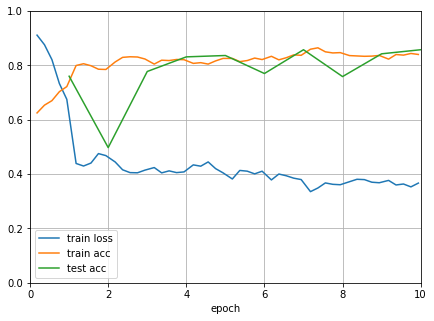

In [27]:
scratch_net = gluon.model_zoo.vision.resnet18_v2(classes=2)
scratch_net.initialize(init=init.Xavier())
train_fine_tuning(scratch_net, 0.1)

As you can see, the fine-tuned model tends to achieve higher precision in the same epoch because the initial values of the parameters are better.

##### Summary
+ Transfer learning migrates the knowledge learned from the source dataset to the target dataset. Fine tuning is a common technique for transfer learning.
+ The target model replicates all model designs and their parameters on the source model, except the output layer, and fine-tunes these parameters based on the target dataset. In contrast, the output layer of the target model needs to be trained from scratch.
+ Generally, fine tuning parameters use a smaller learning rate, while training the output layer from scratch can use a larger learning rate.

##### Exercises
1. Keep increasing the learning rate of finetune_net. How does the precision of the model change?
2. Further tune the hyperparameters of finetune_net and scratch_net in the comparative experiment. Do they still have different precisions?
3. Set the parameters in finetune_net.features to the parameters of the source model and do not update them during training. What will happen? You can use the following code.
```python
finetune_net.features.collect_params().setattr('grad_req', 'null')
```
4. In fact, there is also a "hotdog" class in the ImageNet dataset. Its corresponding weight parameter at the output layer can be obtained by using the following code. How can we use this parameter?
```python
weight = pretrained_net.output.weight
hotdog_w = np.split(weight.data(), 1000, axis=0)[713]
hotdog_w.shape
```

## 13.3 Object Detection and Bounding Boxes
In the previous section, we introduced many models for image classification. In image classification tasks, we assume that there is only one main target in the image and we only focus on how to identify the target category. However, in many situations, there are multiple targets in the image that we are interested in. We not only want to classify them, but also want to obtain their specific positions in the image. In computer vision, we refer to such tasks as `object detection` (or `object recognition`).

Object detection is widely used in many fields. For example, in self-driving technology, we need to plan routes by identifying the locations of vehicles, pedestrians, roads, and obstacles in the captured video image. Robots often perform this type of task to detect targets of interest. Systems in the security field need to detect abnormal targets, such as intruders or bombs.

In the next few sections, we will introduce multiple deep learning models used for object detection. Before that, we should discuss the concept of target location. First, import the packages and modules required for the experiment.

Next, we will load the sample images that will be used in this section. We can see there is a dog on the left side of the image and a cat on the right. They are the two main targets in this image.

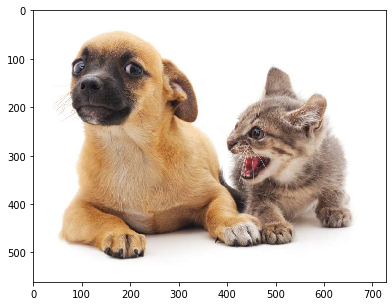

In [28]:
d2l.set_figsize()
img = image.imread('./images/catdog.jpg').asnumpy()
d2l.plt.imshow(img);

### 13.3.1 Bounding Box
In object detection, we usually use a bounding box to describe the target location. The bounding box is a rectangular box that can be determined by the $x$ and $y$ axis coordinates in the upper-left corner and the $x$ and $y$ axis coordinates in the lower-right corner of the rectangle. We will define the bounding boxes of the dog and the cat in the image based on the coordinate information in the above image. The origin of the coordinates in the above image is the upper left corner of the image, and to the right and down are the positive directions of the $x$ axis and the $y$ axis, respectively.

In [29]:
# bbox is the abbreviation for bounding box
dog_bbox, cat_bbox = [60, 45, 378, 516], [400, 112, 655, 493]

We can draw the bounding box in the image to check if it is accurate. Before drawing the box, we will define a helper function `bbox_to_rect`. It represents the bounding box in the bounding box format of matplotlib.

In [30]:
#@save
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (top-left x, top-left y, bottom-right x,
    # bottom-right y) format to matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

After loading the bounding box on the image, we can see that the main outline of the target is basically inside the box.

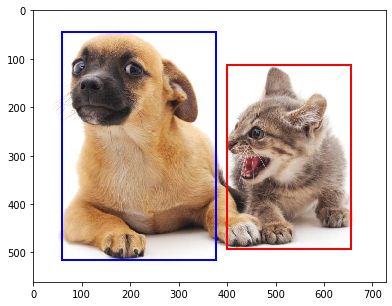

In [31]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

##### Summary
+ In object detection, we not only need to identify all the objects of interest in the image, but also their positions. The positions are generally represented by a rectangular bounding box.

##### Exercises
1. Find some images and try to label a bounding box that contains the target. Compare the difference between the time it takes to label the bounding box and label the category.


## 13.4 Anchor Boxes
Object detection algorithms usually sample a large number of regions in the input image, determine whether these regions contain objects of interest, and adjust the edges of the regions so as to predict the ground-truth bounding box of the target more accurately. Different models may use different region sampling methods. Here, we introduce one such method: it generates multiple bounding boxes with different sizes and aspect ratios while centering on each pixel. These bounding boxes are called `anchor boxes`. We will practice object detection based on anchor boxes in the following sections.

First, import the packages or modules required for this section. Here, we have modified the printing accuracy of `NumPy`. Because printing tensors actually calls the print function of `NumPy`, the floating-point numbers in tensors printed in this section are more concise.

In [32]:
np.set_printoptions(2)
npx.set_np()

### 13.4.1 Generating Multiple Anchor Boxes
Assume that the input image has a height of $h$ and width of $w$. We generate anchor boxes with different shapes centered on each pixel of the image. Assume the size is $s\in (0, 1]$, the aspect ratio is $r > 0$, and the width and height of the anchor box are $ws\sqrt{r}$ and $hs/\sqrt{r}$, respectively. When the center position is given, an anchor box with known width and height is determined.

Below we set a set of sizes $s_1,\ldots, s_n$ and a set of aspect ratios $r_1,\ldots, r_m$. If we use a combination of all sizes and aspect ratios with each pixel as the center, the input image will have a total of $whnm$ anchor boxes. Although these anchor boxes may cover all ground-truth bounding boxes, the computational complexity is often excessive. Therefore, we are usually only interested in a combination containing $s_1$ or $r_1$ sizes and aspect ratios, that is:

$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$

That is, the number of anchor boxes centered on the same pixel is $n+m-1$. For the entire input image, we will generate a total of $wh(n+m-1)$ anchor boxes.

The above method of generating anchor boxes has been implemented in the `multibox_prior` function. We specify the input, a set of sizes, and a set of aspect ratios, and this function will return all the anchor boxes entered.

In [33]:
img = image.imread('./images/catdog.jpg').asnumpy()
h, w = img.shape[0:2]
print(h, w)

X = np.random.uniform(size=(1, 3, h, w))  # Construct input data
Y = npx.multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


(1, 2042040, 4)

We can see that the shape of the returned anchor box variable `y` is `(batch size, number of anchor boxes, 4)`. After changing the shape of the anchor box variable `y` to `(image height, image width, number of anchor boxes centered on the same pixel, 4)`, we can obtain all the anchor boxes centered on a specified pixel position. In the following example, we access the first anchor box centered on `(250, 250)`. It has four elements: the $x, y$ axis coordinates in the upper-left corner and the $x, y$ axis coordinates in the lower-right corner of the anchor box. The coordinate values of the $x$ and $y$ axis are divided by the width and height of the image, respectively, so the value range is between 0 and 1.

In [34]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

array([0.06, 0.07, 0.63, 0.82])

In order to describe all anchor boxes centered on one pixel in the image, we first define the `show_bboxes` function to draw multiple bounding boxes on the image.

In [35]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

As we just saw, the coordinate values of the $x$ and $y$ axis in the variable boxes have been divided by the width and height of the image, respectively. When drawing images, we need to restore the original coordinate values of the anchor boxes and therefore define the variable `bbox_scale`. Now, we can draw all the anchor boxes centered on `(250, 250)` in the image. As you can see, the blue anchor box with a size of 0.75 and an aspect ratio of 1 covers the dog in the image well.

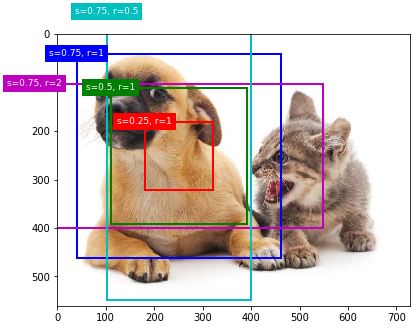

In [36]:
d2l.set_figsize()
bbox_scale = np.array((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2', 's=0.75, r=0.5'])

### 13.4.2 Intersection over Union
We just mentioned that the anchor box covers the dog in the image well. If the ground-truth bounding box of the target is known, how can "well" here be quantified? An intuitive method is to measure the similarity between anchor boxes and the ground-truth bounding box. We know that the `Jaccard index` can measure the similarity between two sets. Given sets $\mathcal{A}$ and $\mathcal{B}$, their `Jaccard index` is the size of their intersection divided by the size of their union:

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$

In fact, we can consider the pixel area of a bounding box as a collection of pixels. In this way, we can measure the similarity of the two bounding boxes by the `Jaccard index` of their pixel sets. When we measure the similarity of two bounding boxes, we usually refer the `Jaccard index` as `intersection over union` (`IoU`), which is the ratio of the intersecting area to the union area of the two bounding boxes, as shown in `Fig. 13.4.1`. The value range of IoU is between 0 and 1: 0 means that there are no overlapping pixels between the two bounding boxes, while 1 indicates that the two bounding boxes are equal.

<img src="images/13_02.png" style="width:600px;"/>

For the remainder of this section, we will use `IoU` to measure the similarity between anchor boxes and ground-truth bounding boxes, and between different anchor boxes.

### 13.4.3 Labeling Training Set Anchor Boxes
In the training set, we consider each anchor box as a training example. In order to train the object detection model, we need to mark two types of labels for each anchor box: first, the category of the target contained in the anchor box (category) and, second, the offset of the ground-truth bounding box relative to the anchor box (offset). In object detection, we first generate multiple anchor boxes, predict the categories and offsets for each anchor box, adjust the anchor box position according to the predicted offset to obtain the bounding boxes to be used for prediction, and finally filter out the prediction bounding boxes that need to be output.

We know that, in the object detection training set, each image is labelled with the location of the ground-truth bounding box and the category of the target contained. After the anchor boxes are generated, we primarily label anchor boxes based on the location and category information of the ground-truth bounding boxes similar to the anchor boxes. So how do we assign ground-truth bounding boxes to anchor boxes similar to them?

Assume that the anchor boxes in the image are $A_1, A_2, \ldots, A_{n_a}$ and the ground-truth bounding boxes are $B_1, B_2, \ldots, B_{n_b}$ and $n_a \geq n_b$. Define matrix $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$, where element $x_{ij}$ in the $i^\mathrm{th}$ row and $j^\mathrm{th}$ column is the IoU of the anchor box $A_i$ to the ground-truth bounding box $B_j$. First, we find the largest element in the matrix $\mathbf{X}$ and record the row index and column index of the element as $i_1,j_1$. We assign the ground-truth bounding box $B_{j_1}$ to the anchor box $A_{i_1}$. Obviously, anchor box $A_{i_1}$ and ground-truth bounding box $B_{j_1}$ have the highest similarity among all the "anchor box--ground-truth bounding box" pairings. Next, discard all elements in the $i_1$th row and the $j_1$th column in the matrix $\mathbf{X}$. Find the largest remaining element in the matrix $\mathbf{X}$ and record the row index and column index of the element as $i_2,j_2$. We assign ground-truth bounding box $B_{j_2}$ to anchor box $A_{i_2}$ and then discard all elements in the $i_2$th row and the $j_2$th column in the matrix $\mathbf{X}$. At this point, elements in two rows and two columns in the matrix $\mathbf{X}$ have been discarded.

We proceed until all elements in the $n_b$ column in the matrix $\mathbf{X}$ are discarded. At this time, we have assigned a ground-truth bounding box to each of the $n_b$ anchor boxes. Next, we only traverse the remaining $n_a - n_b$ anchor boxes. Given anchor box $A_i$, find the bounding box $B_j$ with the largest `IoU` with $A_i$ according to the $i^\mathrm{th}$ row of the matrix $\mathbf{X}$, and only assign ground-truth bounding box $B_j$ to anchor box $A_i$ when the `IoU` is greater than the predetermined threshold.

As shown in `Fig. 13.4.2` (left), assuming that the maximum value in the matrix $\mathbf{X}$ is $x_{23}$, we will assign ground-truth bounding box $B_3$ to anchor box $A_2$. Then, we discard all the elements in row 2 and column 3 of the matrix, find the largest element $x_{71}$ of the remaining shaded area, and assign ground-truth bounding box $B_1$ to anchor box $A_7$. Then, as shown in `Fig. 13.4.2` (middle), discard all the elements in row 7 and column 1 of the matrix, find the largest element $x_{54}$ of the remaining shaded area, and assign ground-truth bounding box $B_4$ to anchor box $A_5$. Finally, as shown in `Fig. 13.4.2` (right), discard all the elements in row 5 and column 4 of the matrix, find the largest element $x_{92}$ of the remaining shaded area, and assign ground-truth bounding box $B_2$ to anchor box $A_9$. After that, we only need to traverse the remaining anchor boxes of $A_1, A_3, A_4, A_6, A_8$ and determine whether to assign ground-truth bounding boxes to the remaining anchor boxes according to the threshold.

<img src="images/13_03.png" style="width:500px;"/>

Now we can label the categories and offsets of the anchor boxes. If an anchor box $A$ is assigned ground-truth bounding box $B$, the category of the anchor box $A$ is set to the category of $B$. And the offset of the anchor box $A$ is set according to the relative position of the central coordinates of $B$ and $A$ and the relative sizes of the two boxes. Because the positions and sizes of various boxes in the dataset may vary, these relative positions and relative sizes usually require some special transformations to make the offset distribution more uniform and easier to fit. Assume the center coordinates of anchor box $A$ and its assigned ground-truth bounding box $B$ are $(x_a, y_a), (x_b, y_b)$, the widths of $A$ and $B$ are $w_a, w_b$, and their heights are $h_a, h_b$, respectively. In this case, a common technique is to label the offset of $A$ as

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x}, \frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y}, \frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w}, \frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

The default values of the constant are $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$, and $\sigma_w=\sigma_h=0.2$. If an anchor box is not assigned a ground-truth bounding box, we only need to set the category of the anchor box to background. Anchor boxes whose category is background are often referred to as negative anchor boxes, and the rest are referred to as positive anchor boxes.

Below we demonstrate a detailed example. We define ground-truth bounding boxes for the cat and dog in the read image, where the first element is category (0 for dog, 1 for cat) and the remaining four elements are the $x, y$ axis coordinates at top-left corner and $x, y$ axis coordinates at lower-right corner (the value range is between 0 and 1). Here, we construct five anchor boxes to be labeled by the coordinates of the upper-left corner and the lower-right corner, which are recorded as $A_0, \ldots, A_4$, respectively (the index in the program starts from 0). First, draw the positions of these anchor boxes and the ground-truth bounding boxes in the image.

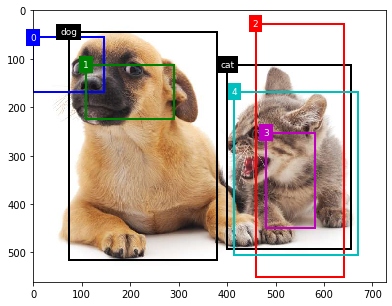

In [37]:
ground_truth = np.array([[0, 0.1, 0.08, 0.52, 0.92],[1, 0.55, 0.2, 0.9, 0.88]])
anchors = np.array([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4], [0.63, 0.05, 0.88, 0.98], 
                    [0.66, 0.45, 0.8, 0.8], [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

We can label categories and offsets for anchor boxes by using the `multibox_target` function. This function sets the background category to 0 and increments the integer index of the target category from zero by 1 (1 for dog and 2 for cat). We add example dimensions to the anchor boxes and ground-truth bounding boxes and construct random predicted results with a shape of `(batch size, number of categories including background, number of anchor boxes)` by using the `expand_dims` function.

In [38]:
labels = npx.multibox_target(np.expand_dims(anchors, axis=0),
                             np.expand_dims(ground_truth, axis=0),
                             np.zeros((1, 3, 5)))

There are three items in the returned result, all of which are in the `tensor` format. The third item is represented by the category labeled for the anchor box.

In [39]:
labels[2]

array([[0., 1., 2., 0., 2.]])

We analyze these labelled categories based on positions of anchor boxes and ground-truth bounding boxes in the image. First, in all "anchor box--ground-truth bounding box" pairs, the IoU of anchor box $A_4$ to the ground-truth bounding box of the cat is the largest, so the category of anchor box $A_4$ is labeled as cat. Without considering anchor box $A_4$ or the ground-truth bounding box of the cat, in the remaining "anchor box--ground-truth bounding box" pairs, the pair with the largest IoU is anchor box $A_1$ and the ground-truth bounding box of the dog, so the category of anchor box $A_1$ is labeled as dog. Next, traverse the remaining three unlabeled anchor boxes. The category of the ground-truth bounding box with the largest IoU with anchor box $A_0$ is dog, but the IoU is smaller than the threshold (the default is 0.5), so the category is labeled as background; the category of the ground-truth bounding box with the largest IoU with anchor box $A_2$ is cat and the IoU is greater than the threshold, so the category is labeled as cat; the category of the ground-truth bounding box with the largest IoU with anchor box $A_3$ is cat, but the IoU is smaller than the threshold, so the category is labeled as background.

The second item of the return value is a mask variable, with the shape of `(batch size, four times the number of anchor boxes)`. The elements in the mask variable correspond one-to-one with the four offset values of each anchor box. Because we do not care about background detection, offsets of the negative class should not affect the target function. By multiplying by element, the 0 in the mask variable can filter out negative class offsets before calculating target function.

In [40]:
labels[1]

array([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1.]])

The first item returned is the four offset values labeled for each anchor box, with the offsets of negative class anchor boxes labeled as 0.

In [41]:
labels[0]

array([[ 0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00,  1.40e+00,  1.00e+01,
         2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         0.00e+00,  0.00e+00,  0.00e+00,  0.00e+00, -5.71e-01, -1.00e+00,
        -8.94e-07,  6.26e-01]])

### 13.4.4 Bounding Boxes for Prediction
During model prediction phase, we first generate multiple anchor boxes for the image and then predict categories and offsets for these anchor boxes one by one. Then, we obtain prediction bounding boxes based on anchor boxes and their predicted offsets. When there are many anchor boxes, many similar prediction bounding boxes may be output for the same target. To simplify the results, we can remove similar prediction bounding boxes. A commonly used method is called `non-maximum suppression` (`NMS`).

Let us take a look at how `NMS` works. For a prediction bounding box $B$, the model calculates the predicted probability for each category. Assume the largest predicted probability is $p$, the category corresponding to this probability is the predicted category of $B$. We also refer to $p$ as the confidence level of prediction bounding box $B$. On the same image, we sort the prediction bounding boxes with predicted categories other than background by confidence level from high to low, and obtain the list $L$. Select the prediction bounding box $B_1$ with highest confidence level from $L$ as a baseline and remove all non-benchmark prediction bounding boxes with an IoU with $B_1$ greater than a certain threshold from $L$. The threshold here is a preset hyperparameter. At this point, $L$ retains the prediction bounding box with the highest confidence level and removes other prediction bounding boxes similar to it. Next, select the prediction bounding box $B_2$ with the second highest confidence level from $L$ as a baseline, and remove all non-benchmark prediction bounding boxes with an IoU with $B_2$ greater than a certain threshold from $L$. Repeat this process until all prediction bounding boxes in $L$ have been used as a baseline. At this time, the IoU of any pair of prediction bounding boxes in $L$ is less than the threshold. Finally, output all prediction bounding boxes in the list $L$.

Next, we will look at a detailed example. First, construct four anchor boxes. For the sake of simplicity, we assume that predicted offsets are all 0. This means that the prediction bounding boxes are anchor boxes. Finally, we construct a predicted probability for each category.

In [42]:
anchors = np.array([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                    [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = np.array([0] * anchors.size)
cls_probs = np.array([[0] * 4,  # Predicted probability for background
                      [0.9, 0.8, 0.7, 0.1],  # Predicted probability for dog
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted probability for cat

Print prediction bounding boxes and their confidence levels on the image.

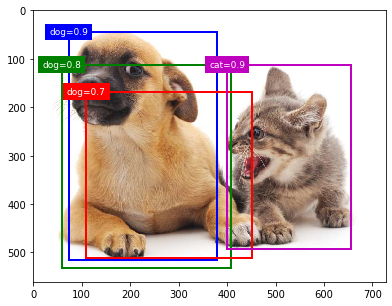

In [43]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

We use the `multibox_detection` function to perform NMS and set the threshold to 0.5. This adds an example dimension to the tensor input. We can see that the shape of the returned result is `(batch size, number of anchor boxes, 6)`. The 6 elements of each row represent the output information for the same prediction bounding box. The first element is the predicted category index, which starts from 0 (0 is dog, 1 is cat). The value -1 indicates background or removal in NMS. The second element is the confidence level of prediction bounding box. The remaining four elements are the $x, y$ axis coordinates of the upper-left corner and the $x, y$ axis coordinates of the lower-right corner of the prediction bounding box (the value range is between 0 and 1).

In [44]:
output = npx.multibox_detection(
    np.expand_dims(cls_probs, axis=0),
    np.expand_dims(offset_preds, axis=0),
    np.expand_dims(anchors, axis=0),
    nms_threshold=0.5)
output

array([[[ 0.  ,  0.9 ,  0.1 ,  0.08,  0.52,  0.92],
        [ 1.  ,  0.9 ,  0.55,  0.2 ,  0.9 ,  0.88],
        [-1.  ,  0.8 ,  0.08,  0.2 ,  0.56,  0.95],
        [-1.  ,  0.7 ,  0.15,  0.3 ,  0.62,  0.91]]])

We remove the prediction bounding boxes of category -1 and visualize the results retained by NMS.

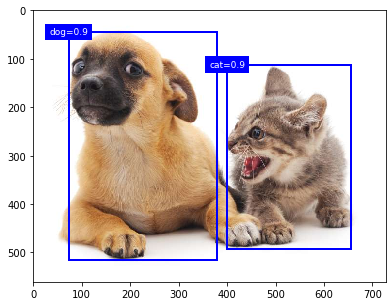

In [45]:
fig = d2l.plt.imshow(img)
for i in output[0].asnumpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [np.array(i[2:]) * bbox_scale], label)

In practice, we can remove prediction bounding boxes with lower confidence levels before performing NMS, thereby reducing the amount of computation for NMS. We can also filter the output of NMS, for example, by only retaining results with higher confidence levels as the final output.

##### Summary
+ We generate multiple anchor boxes with different sizes and aspect ratios, centered on each pixel.
+ `IoU`, also called `Jaccard index`, measures the similarity of two bounding boxes. It is the ratio of the intersecting area to the union area of two bounding boxes.
+ In the training set, we mark two types of labels for each anchor box: one is the category of the target contained in the anchor box and the other is the offset of the ground-truth bounding box relative to the anchor box.
+ When predicting, we can use `non-maximum suppression` (`NMS`) to remove similar prediction bounding boxes, thereby simplifying the results.

##### Exercises
1. Change the `sizes` and `ratios` values in the `multibox_prior` function and observe the changes to the generated anchor boxes.
2. Construct two bounding boxes with and `IoU` of `0.5`, and observe their coincidence.
3. Verify the output of offset `labels[0]` by marking the anchor box offsets as defined in this section (the constant is the default value).
4. Modify the variable anchors in the "Labeling Training Set Anchor Boxes" and "Output Bounding Boxes for Prediction" sections. How do the results change?


## 13.5 Multiscale Object Detection
In `Section 13.4`, we generated multiple anchor boxes centered on each pixel of the input image. These anchor boxes are used to sample different regions of the input image. However, if anchor boxes are generated centered on each pixel of the image, soon there will be too many anchor boxes for us to compute. For example, we assume that the input image has a height and a width of 561 and 728 pixels respectively. If five different shapes of anchor boxes are generated centered on each pixel, over two million anchor boxes ($561 \times 728 \times 5$) need to be predicted and labeled on the image.

It is not difficult to reduce the number of anchor boxes. An easy way is to apply uniform sampling on a small portion of pixels from the input image and generate anchor boxes centered on the sampled pixels. In addition, we can generate anchor boxes of varied numbers and sizes on multiple scales. Notice that smaller objects are more likely to be positioned on the image than larger ones. Here, we will use a simple example: Objects with shapes of $1 \times 1$, $1 \times 2$, and $2 \times 2$ may have 4, 2, and 1 possible position(s) on an image with the shape $2 \times 2$. Therefore, when using smaller anchor boxes to detect smaller objects, we can sample more regions; when using larger anchor boxes to detect larger objects, we can sample fewer regions.

To demonstrate how to generate anchor boxes on multiple scales, let us read an image first. It has a height and width of $561 \times 728$ pixels.

In [46]:
img = image.imread('./images/catdog.jpg')
h, w = img.shape[0:2]
h, w

(561, 728)

In `Section 6.2`, the 2D array output of the `convolutional neural network` (`CNN`) is called a `feature map`. We can determine the midpoints of anchor boxes uniformly sampled on any image by defining the shape of the feature map.

The function `display_anchors` is defined below. We are going to generate anchor boxes anchors centered on each unit (pixel) on the feature map `fmap`. Since the coordinates of axes $x$ and $y$ in anchor boxes anchors have been divided by the width and height of the feature map `fmap`, values between 0 and 1 can be used to represent relative positions of anchor boxes in the feature map. Since the midpoints of anchor boxes anchors overlap with all the units on feature map fmap, the relative spatial positions of the midpoints of the anchors on any image must have a uniform distribution. Specifically, when the width and height of the feature map are set to `fmap_w` and `fmap_h` respectively, the function will conduct uniform sampling for `fmap_h` rows and `fmap_w` columns of pixels and use them as midpoints to generate anchor boxes with size s (we assume that the length of list s is 1) and different aspect ratios (`ratios`).

In [47]:
def display_anchors(fmap_w, fmap_h, s):
    d2l.set_figsize()
    # The values from the first two dimensions will not affect the output
    fmap = np.zeros((1, 10, fmap_w, fmap_h))
    anchors = npx.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    bbox_scale = np.array((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img.asnumpy()).axes, anchors[0] * bbox_scale)

We will first focus on the detection of small objects. In order to make it easier to distinguish upon display, the anchor boxes with different midpoints here do not overlap. We assume that the size of the anchor boxes is 0.15 and the height and width of the feature map are 4. We can see that the midpoints of anchor boxes from the 4 rows and 4 columns on the image are uniformly distributed.

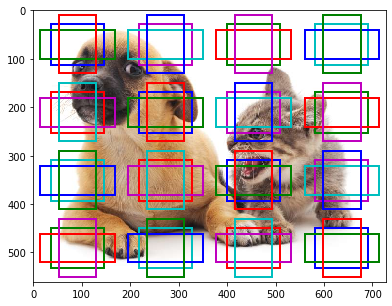

In [48]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

We are going to reduce the height and width of the feature map by half and use a larger anchor box to detect larger objects. When the size is set to 0.4, overlaps will occur between regions of some anchor boxes.

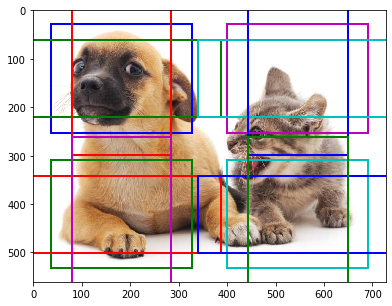

In [49]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4])

Finally, we are going to reduce the height and width of the feature map by half and increase the anchor box size to 0.8. Now the midpoint of the anchor box is the center of the image.

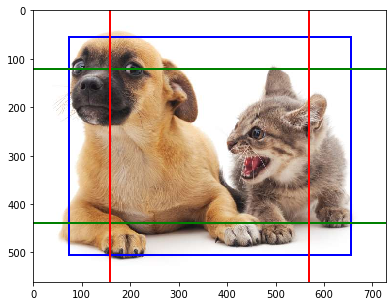

In [50]:
display_anchors(fmap_w=1, fmap_h=1, s=[0.8])

Since we have generated anchor boxes of different sizes on multiple scales, we will use them to detect objects of various sizes at different scales. Now we are going to introduce a method based on convolutional neural networks (CNNs).

At a certain scale, suppose we generate $h \times w$ sets of anchor boxes with different midpoints based on $c_i$ feature maps with the shape $h \times w$ and the number of anchor boxes in each set is $a$. For example, for the first scale of the experiment, we generate 16 sets of anchor boxes with different midpoints based on 10 (number of channels) feature maps with a shape of $4 \times 4$, and each set contains 3 anchor boxes. Next, each anchor box is labeled with a category and offset based on the classification and position of the ground-truth bounding box. At the current scale, the object detection model needs to predict the category and offset of $h \times w$ sets of anchor boxes with different midpoints based on the input image.

We assume that the $c_i$ feature maps are the intermediate output of the CNN based on the input image. Since each feature map has $h \times w$ different spatial positions, the same position will have $c_i$ units. According to the definition of receptive field in the `Section 6.2`, the $c_i$ units of the feature map at the same spatial position have the same receptive field on the input image. Thus, they represent the information of the input image in this same receptive field. Therefore, we can transform the $c_i$ units of the feature map at the same spatial position into the categories and offsets of the $a$ anchor boxes generated using that position as a midpoint. It is not hard to see that, in essence, we use the information of the input image in a certain receptive field to predict the category and offset of the anchor boxes close to the field on the input image.

When the feature maps of different layers have receptive fields of different sizes on the input image, they are used to detect objects of different sizes. For example, we can design a network to have a wider receptive field for each unit in the feature map that is closer to the output layer, to detect objects with larger sizes in the input image.

We will implement a multiscale object detection model in the following section.

##### Summary
+ We can generate anchor boxes with different numbers and sizes on multiple scales to detect objects of different sizes on multiple scales.
+ The shape of the feature map can be used to determine the midpoint of the anchor boxes that uniformly sample any image.
+ We use the information for the input image from a certain receptive field to predict the category and offset of the anchor boxes close to that field on the image.

##### Exercises
1. Given an input image, assume $1 \times c_i \times h \times w$ to be the shape of the feature map while $c_i, h, w$ are the number, height, and width of the feature map. What methods can you think of to convert this variable into the anchor box's category and offset? What is the shape of the output?